In [34]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image, ImageChops
from sklearn.neighbors import KernelDensity
import random
import cv2

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
cd 'drive/My Drive'

[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive


In [40]:
# Create generators for training, validation and testing
# Generate data from the images in a folder, allows use of datasets that do not fit in main memory all at once
# Image resizing is done by the generator so a folder with any sized-images can be used
# The named directory must contain one or more subfolders, path should look like apples_train/apple_class1/img1.jpg...
batch_size = 85


train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    data_format='channels_last',                               
    horizontal_flip=True,
    validation_split=0.2) # set validation split

In [41]:
train_datagen.flow_from_directory('flowers/')

Found 4317 images belonging to 5 classes.


In [42]:
# Create generators for training, validation and testing
# Generate data from the images in a folder, allows use of datasets that do not fit in main memory all at once
# Image resizing is done by the generator so a folder with any sized-images can be used
# The named directory must contain one or more subfolders, path should look like apples_train/apple_class1/img1.jpg...



#train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
train_generator = train_datagen.flow_from_directory(
    'flowers/',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='input',
    subset='training',# set as training data
    classes=['sunflower'],
    color_mode="rgb"
    )

#test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
validation_generator = train_datagen.flow_from_directory(
    'flowers/',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='input',
    subset='validation', # set as validation data
    classes=['sunflower']
    )

anomaly_generator = train_datagen.flow_from_directory(
    'flowers/',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='input',
    classes=['rose'],
    color_mode="rgb",
    )

Found 587 images belonging to 1 classes.
Found 146 images belonging to 1 classes.
Found 784 images belonging to 1 classes.


In [44]:
# Define the convolutional autoencoder model 
# input shape must be the same size as the images that will be fed into it by the generators
# The output layer must be the same dimensions as the original image
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same',activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(pool_size=(4,4), padding='same')) # using pool_size (4,4) makes the layer 4x smaller in height and width

model.add(Conv2D(8,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(4,4), padding='same'))

model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#-------------------------
model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(8,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((4, 4)))

model.add(Conv2D(16,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((4, 4)))

model.add(Conv2D(3,(3, 3), activation='sigmoid', padding='same'))
#-------------------------

model.summary()

# Compile the model
model.compile(optimizer='adam', loss='mse')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 24, 24, 8)         1160      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 6, 6, 3)           219       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 3, 3, 3)         

In [45]:
model_filepath = 'models/model1.keras'

In [46]:
# Training the model
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30) # Early stopping (stops training when validation doesn't improve for {patience} epochs)
model_filepath = 'models/model1.keras'
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min') # Saves the best version of the model to disk (as measured on the validation data set)
result=model.fit_generator(
        train_generator,
        steps_per_epoch=600 // batch_size,
        epochs=600,
        #epochs=10,
        validation_data=validation_generator,
        validation_steps=200 // batch_size,
        shuffle = True,
        callbacks=[es, save_best])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/600
7/7 [==============================] - 7s 987ms/step - loss: 0.0915 - val_loss: 0.0890
Epoch 2/600
7/7 [==============================] - 6s 834ms/step - loss: 0.0802 - val_loss: 0.0844
Epoch 3/600
7/7 [==============================] - 5s 802ms/step - loss: 0.0756 - val_loss: 0.0853
Epoch 4/600
7/7 [==============================] - 6s 850ms/step - loss: 0.0729 - val_loss: 0.0798
Epoch 5/600
7/7 [==============================] - 6s 804ms/step - loss: 0.0711 - val_loss: 0.0785
Epoch 6/600
7/7 [==============================] - 6s 824ms/step - loss: 0.0701 - val_loss: 0.0784
Epoch 7/600
7/7 [==============================] - 6s 807ms/step - loss: 0.0688 - val_loss: 0.0770
Epoch 8/600
7/7 [==============================] - 6s 805ms/step - loss: 0.0677 - val_loss: 0.0756
Epoch 9/600
7/7 [==============================] - 5s 802ms/step - loss: 0.0670 - val_loss: 0.0748
Epoch 10/600
7/7 [==============================] - 6s 817ms/step - loss: 0.0668 - val_loss: 0.0745
Epoch 11/

In [9]:
# Training continues after improvement stops for the number of epochs equivalent to the 'patience' hyper-parameter
# To get back the model that performed best on the validation set we load the checkpointed model from disk:
model = keras.models.load_model(model_filepath)

In [10]:
model_filepath

'models/model1.keras'

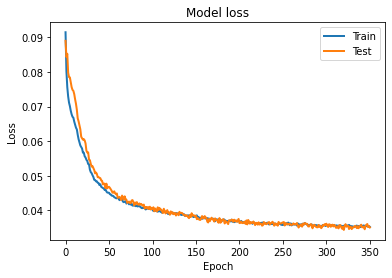

In [47]:
plt.plot(result.history['loss'], linewidth=2, label='Train')
plt.plot(result.history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

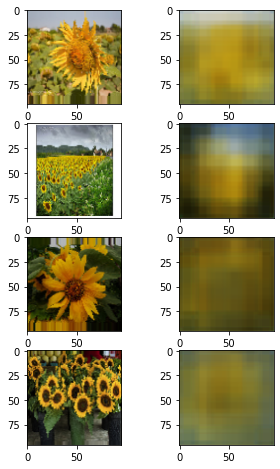

In [11]:
# Test the model by viewing a sample of original and reconstructed images
data_list = []
batch_index = 0
while batch_index <= train_generator.batch_index:
    data = train_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

predicted = model.predict(data_list[0])
no_of_samples = 4
_, axs = plt.subplots(no_of_samples, 2, figsize=(5, 8))
axs = axs.flatten()
imgs = []
for i in range(no_of_samples):
    imgs.append(data_list[i][i])
    imgs.append(predicted[i])
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [12]:
# We want the difference the difference in error between the validation (normal) images and anomalous images to be as high as possible
print(f"Error on validation set:{model.evaluate_generator(validation_generator)}, error on anomaly set:{model.evaluate_generator(anomaly_generator)}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


Error on validation set:0.03633616119623184, error on anomaly set:0.04190712049603462


In [13]:
# We build a replica of the first half of the auto-encoder (the encoder only)
# This network takes a an image which is 96x96x3 and compresses it down to a 3x3x3 tensor
encoder_replica = Sequential()
encoder_replica.add(Conv2D(16, (3, 3), padding='same',activation='relu', input_shape=(96, 96, 3), weights=model.layers[0].get_weights()) )
encoder_replica.add(MaxPooling2D(pool_size=(4,4), padding='same'))
encoder_replica.add(Conv2D(8,(3, 3),activation='relu',  padding='same', weights=model.layers[2].get_weights()))
encoder_replica.add(MaxPooling2D(pool_size=(4,4), padding='same'))
encoder_replica.add(Conv2D(3,(3, 3),activation='relu',  padding='same', weights=model.layers[4].get_weights()))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same'))
encoder_replica.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 8)         1160      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 8)          0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 6, 6, 3)           219       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 3)         

In [15]:
x, y, c = train_generator.image_shape

In [19]:
# Creating encoded (compressed versions of the training, validation and anomalous images) and getting their density
# The SKLearn kernel density function only works with 1D arrays so we need to flatten the tensors created by the encoder
encoded_images = encoder_replica.predict_generator(train_generator)
encoded_images_flat = [np.reshape(img, (27)) for img in encoded_images]

validation_encoded = encoder_replica.predict_generator(validation_generator)
val_enc_flat = [np.reshape(img, (27)) for img in validation_encoded]

anom_encoded = encoder_replica.predict_generator(anomaly_generator)
anom_enc_flat = [np.reshape(img, (27)) for img in anom_encoded]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


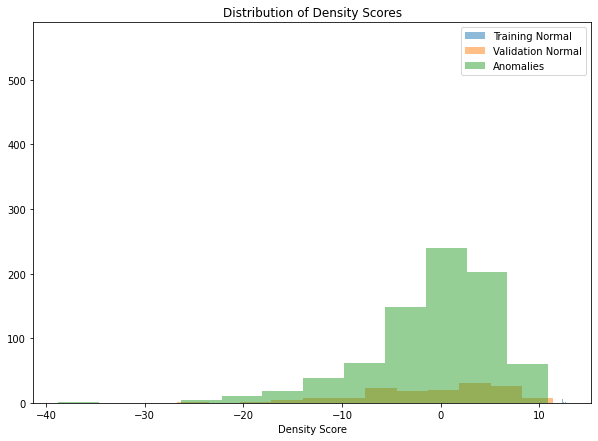

In [20]:
# Kernel Density Estimation of the encoded vectors
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_flat)
training_density_scores = kde.score_samples(encoded_images_flat) 
validation_density_scores = kde.score_samples(val_enc_flat)
anomaly_density_scores = kde.score_samples(anom_enc_flat)

# Plotting the density distributions of the training (normal), validation (normal) and anomalous images
# Ideally we want to see high separation between the normal and anomalous classes
plt.figure(figsize = (10,7))
plt.title('Distribution of Density Scores')
plt.hist(training_density_scores, 12, alpha=0.5, label='Training Normal')
plt.hist(validation_density_scores, 12, alpha=0.5, label='Validation Normal')
plt.hist(anomaly_density_scores, 12, alpha=0.5, label='Anomalies')
plt.legend(loc='upper right')
plt.xlabel('Density Score')

plt.show()

In [21]:
# Creat a function that will classify whether an unseen image is normal or an anomaly
# Low density and high reconstruction error mean that the image is likely to be anomalous
def check_anomaly(img_path):
    IMG_SIZE = 96
    img_array = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    img=new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    density_threshold = 0 # This threshold was chosen based on looking at the distribution of the density scores of the normal class (validation set)
    reconstruction_error_threshold = 0.04 # This threshold was chosen based on looking at the distribution of reconstruction errors of the normal class
    #img  = Image.open(img_path)
    #img = np.array(img.resize((96,96), Image.ANTIALIAS))
    #img = img / 255
    encoded_img = encoder_replica.predict([[img]]) # Create a compressed version of the image using the encoder
    encoded_img = [np.reshape(img, (27)) for img in encoded_img] # Flatten the compressed image
    density = kde.score_samples(encoded_img)[0] # get a density score for the new image
#     print(f'density: {density}')
    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)
#     print(f'reconstruction_error: {reconstruction_error}')
    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        return True
    else:
        return False

In [24]:
# Check what proportion of rose images are classified as anomalous
rose_files = []
for (dirpath, dirnames, filenames) in os.walk('flowers/rose'):
    for x in filenames:
        if x.endswith(".jpg"):
            rose_files.append(os.path.join(dirpath, x))

rose_predictions = []
for file in rose_files:
    rose_predictions.append(check_anomaly(file))
print(sum(rose_predictions)/len(rose_predictions))


1/1 [==============================] - 0s 30ms/step - loss: 23303.7930
1.0


In [25]:
# Check what proportion of apples are classified as anomalous (we hope that this will be close to zero)
dandelion_test = []
for (dirpath, dirnames, filenames) in os.walk('flowers/dandelion'):
    for x in filenames:
        if x.endswith(".jpg"):
            dandelion_test.append(os.path.join(dirpath, x))

dandelion_predictions = []
for file in dandelion_test:
    dandelion_predictions.append(check_anomaly(file))
print(sum(dandelion_predictions)/len(dandelion_predictions))

1/1 [==============================] - 0s 24ms/step - loss: 9826.3164
1.0


In [32]:
# Check what proportion of aubergines/eggplants get classed as anomalous.
tulip_test = []
for (dirpath, dirnames, filenames) in os.walk('flowers/tulip'):
    for x in filenames:
        if x.endswith(".jpg"):
            tulip_test.append(os.path.join(dirpath, x))

tulip_predictions = []
for file in tulip_test:
    tulip_predictions.append(check_anomaly(file))
print(sum(tulip_predictions)/len(tulip_predictions))


1/1 [==============================] - 0s 25ms/step - loss: 9799.8789
1.0


In [33]:
daisy_test = []
for (dirpath, dirnames, filenames) in os.walk('flowers/daisy'):
    for x in filenames:
        if x.endswith(".jpg"):
            daisy_test.append(os.path.join(dirpath, x))

daisy_predictions = []
for file in daisy_test:
    daisy_predictions.append(check_anomaly(file))
print(sum(daisy_predictions)/len(daisy_predictions))

1/1 [==============================] - 0s 26ms/step - loss: 12286.3184
1.0
